In [12]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Allow notebook to import from the 'src' directory
sys.path.append(os.path.abspath('../src'))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
import joblib
import shap

In [2]:
from model_train import train_and_evaluate 

In [ ]:
ecommerce_df = pd.read_csv('../data/processed/processed_fraud_data.csv')

In [4]:
# Select engineered features + original numeric ones
e_features = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 
              'day_of_week', 'device_id_count', 'ip_address_count']
X_e = ecommerce_df[e_features]
y_e = ecommerce_df['class']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_e, y_e, test_size=0.2, random_state=42, stratify=y_e
)

In [5]:
# --- DATASET 2: BANK CREDIT (creditcard.csv) ---
credit_df = pd.read_csv('../data/raw/creditcard.csv')

In [6]:
# Pre-processing: Scale 'Time' and 'Amount' (V1-V28 are already scaled/PCA'd)
scaler = StandardScaler()
credit_df['Time'] = scaler.fit_transform(credit_df[['Time']])
credit_df['Amount'] = scaler.fit_transform(credit_df[['Amount']])

X_c = credit_df.drop('Class', axis=1)
y_c = credit_df['Class']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)

In [7]:
# train for both datasets fruad and credit
train_and_evaluate(X_train_e, X_test_e, y_train_e, y_test_e, "E-Commerce Fraud")
train_and_evaluate(X_train_c, X_test_c, y_train_c, y_test_c, "Bank Credit Fraud")


==== Results for E-Commerce Fraud ====
Logistic Regression: F1-Score = 0.6646 | AUPRC = 0.6232
Random Forest: F1-Score = 0.6104 | AUPRC = 0.7028

==== Results for Bank Credit Fraud ====
Logistic Regression: F1-Score = 0.1141 | AUPRC = 0.7189
Random Forest: F1-Score = 0.8100 | AUPRC = 0.8144


In [8]:
# --- 1. Train E-commerce Model ---
rf_model_e = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model_e.fit(X_train_e, y_train_e)

# --- 2. Train Bank Credit Model ---
rf_model_c = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model_c.fit(X_train_c, y_train_c)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Feature Importance Baseline

In [9]:
def plot_builtin_importance(model, features, title):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
    plt.title(f'Top 10 Built-in Feature Importances: {title}')
    plt.xlabel('Importance Score')
    plt.show()

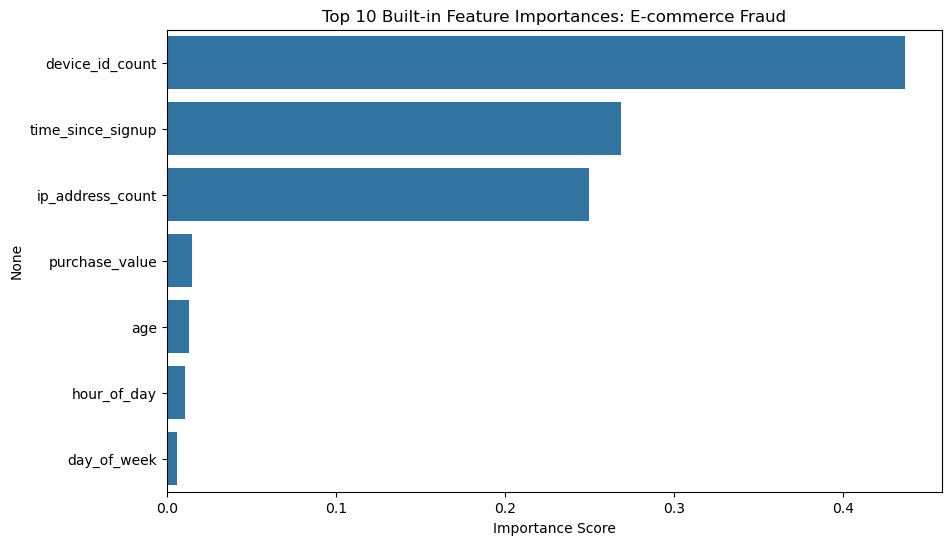

In [10]:
# Run for E-commerce
plot_builtin_importance(rf_model_e, X_e.columns, "E-commerce Fraud")


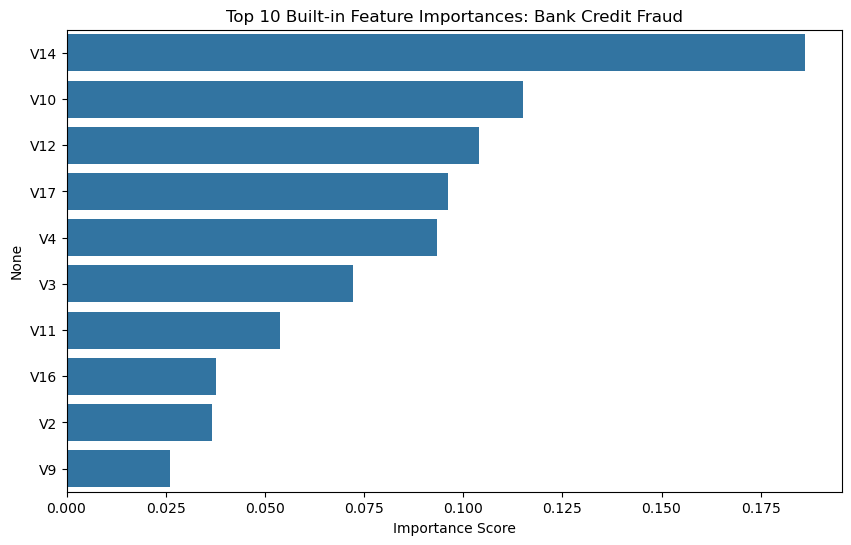

In [11]:
# Run for Bank Credit
plot_builtin_importance(rf_model_c, X_c.columns, "Bank Credit Fraud")

### SHAP Analysis

SHAP Summary Plot: E-commerce


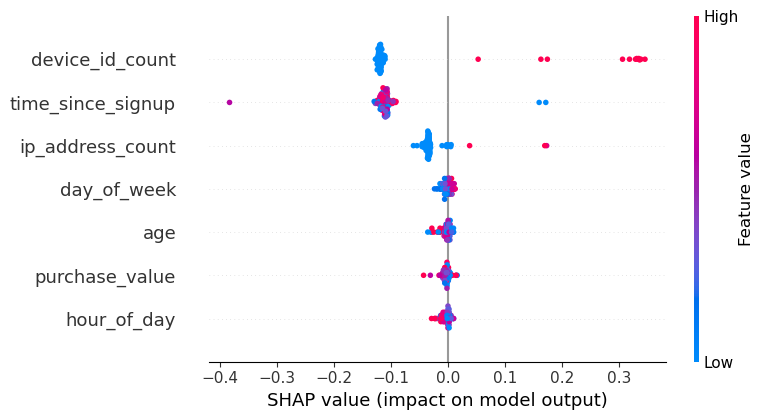

In [14]:
# Initialize JavaScript for force plots
shap.initjs()

# We use a sample for speed
X_sample_e = X_test_e.sample(100, random_state=42)
explainer_e = shap.TreeExplainer(rf_model_e)
shap_values_e = explainer_e.shap_values(X_sample_e)

print("SHAP Summary Plot: E-commerce")
# Syntax: shap_values[all_samples, all_features, class_1]
shap.summary_plot(shap_values_e[:, :, 1], X_sample_e)

SHAP Summary Plot: Bank Credit Fraud


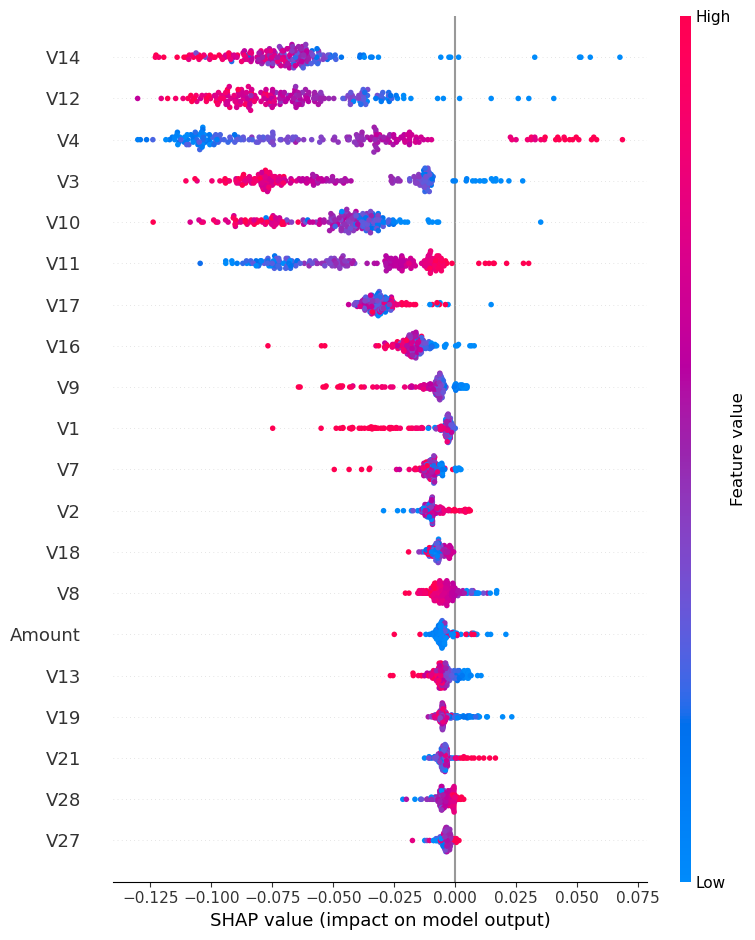

In [15]:
# 1. Initialize the Explainer
explainer_c = shap.TreeExplainer(rf_model_c)

# 2. Sample the data (100-200 samples is usually enough for a stable summary)
X_sample_c = X_test_c.sample(200, random_state=42)
shap_values_c = explainer_c.shap_values(X_sample_c)

# 3. Summary Plot for Class 1 (Fraud)
print("SHAP Summary Plot: Bank Credit Fraud")
shap.summary_plot(shap_values_c[:, :, 1], X_sample_c)